# Homework 4

## Dataset

In [ ]:
!curl -o homework_4/data.csv https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: Failed to open the file homework_4/data.csv: No such file or directory
  0 80876    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
curl: (56) Failure writing output to destination, passed 824 returned 4294967295


## Data Preparation

The target variable is `converted`
* check if the missing values are presented in the features
* if there are missing values:
    * for categorical features, replace withh 'NA'
    * for numerical features, replace with 0.0

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv("data.csv")

In [4]:
data.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [5]:
categorical = data.select_dtypes(include="object").columns.to_list()
numerical = data.select_dtypes(exclude="object").columns.to_list()
data.isna().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [6]:
data[categorical] = data[categorical].fillna("NA")
data[numerical] = data[numerical].fillna(0.0)
data.isna().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. use `train_test_split` function for that with `random_state=1`

In [7]:
from sklearn.model_selection import train_test_split
# separate target variable from the rest of the data
y = data['converted']
data = data.drop(columns='converted')
numerical.remove('converted')
data_full_train, data_test, y_full_train, y_test = train_test_split(data, y, test_size=0.2, random_state=1)
data_train, data_val, y_train, y_val = train_test_split(data_full_train, y_full_train, test_size=0.25, random_state=1)

## Question 1
ROC AUC could also be used to evaluate featuer importance of numerical variables
Let's do that:
* For each numerical variable, use it as a score (aka prediction) and compute the AUC with y variable as the ground truth
* Use the training dataset for that

If your AUC < 0.5, invert this variabel by putting "-" in front of it (e.g., `-df_train['balance']`)
AUC can fo below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correation by negating this variable - then the negative correlation becomes positive

Which numerical variable (among the following 4) has the highest AUC?
    

In [8]:
from sklearn.metrics import roc_auc_score
score = dict()
for variable in numerical:
    auc = roc_auc_score(y_train, data_train[variable])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -data_train[variable])
    score[variable] = auc

print(f"The numerical variable with the highest AUC is {max(score, key=score.get)}")

The numerical variable with the highest AUC is number_of_courses_viewed


## Question 2:
Apply one-hot encoding using DictVectorizer and train the logistic regression with these parameters:

`LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`

What's the AUC of this model on the validation dataset? (round to 3 digits)

In [11]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

def train(df_train, y_train, C = 1.0):
    dv = DictVectorizer(sparse=False)
    dicts_train = df_train[numerical + categorical].to_dict(orient='records')
    X_train = dv.fit_transform(dicts_train)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    return dv, model

dv, model = train(data_train, y_train)
dicts_val = data_val.to_dict(orient='records')
X_val = dv.transform(dicts_val)
y_pred_val = model.predict_proba(X_val)[:,1]

auc = roc_auc_score(y_val, y_pred_val)

print(f"The AUC of this model is {auc:.3f}")

The AUC of this model is 0.817


## Question 3:
Now let's compute precision and recal for our model.
* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

In [13]:
from sklearn.metrics import precision_score, recall_score
thresholds = np.arange(0, 1+0.01, 0.01)
precision = []
recall = []
f1_score = []
valid_thresholds = []
for t in thresholds:
    y_pred = (y_pred_val >= t).astype(int)
    if y_pred.sum() == 0:
        continue
    p = precision_score(y_val, y_pred) #warnings caused by zero division. can be fixed by setting zero_division = 0 or np.nan for example
    r = recall_score(y_val, y_pred)
    precision.append(p) 
    recall.append(r)
    valid_thresholds.append(t)

# find the threshold where precision and recall intersect
p = np.array(precision)
r = np.array(recall)
intersect_idx = np.argmin(np.abs(p-r))
intersect_threshold = valid_thresholds[intersect_idx]
# find precision and recal at that threshold
p_intersect = precision[intersect_idx]
r_intersect = recall[intersect_idx]
print(f" The threshold where precision and recall are the same is {intersect_threshold}")


 The threshold where precision and recall are the same is 0.64


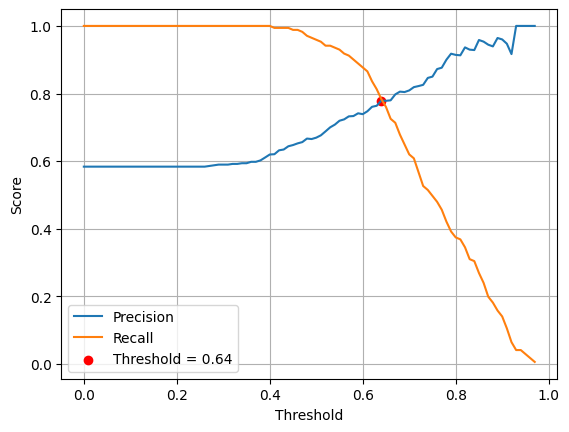

In [14]:
%matplotlib inline
plt.plot(valid_thresholds, precision, label='Precision')
plt.plot(valid_thresholds, recall, label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.scatter(intersect_threshold, p_intersect, color='red', label = f"Threshold = {intersect_threshold:.2f}")
plt.legend()
plt.grid(True)


## Question 4:
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both. This is the formula for computing F1
$$
F_1 = 2.\frac{P.R}{P+R}
$$

Where $P$ is precisino and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01
At which threshold F1 is maximal?

In [15]:
thresholds = np.arange(0, 1+0.01, 0.01)
precision = []
recall = []
f1_score = []
valid_thresholds = []
for t in thresholds:
    y_pred = (y_pred_val >= t).astype(int)
    if y_pred.sum() == 0:
        continue
    p = precision_score(y_val, y_pred, zero_division=np.nan)
    r = recall_score(y_val, y_pred, zero_division=np.nan)
    precision.append(p) #warnings caused by zero division. can be fixed by setting zero_division = 0 for example
    recall.append(r)
    f1 = 2*((p*r)/(p+r))
    f1_score.append(f1)
    valid_thresholds.append(t)

f1 = np.array(f1_score)
t_f1 = valid_thresholds[np.argmax(f1)]

print(f"The threshold at which F1 is max is {t_f1:.2f}")


The threshold at which F1 is max is 0.57


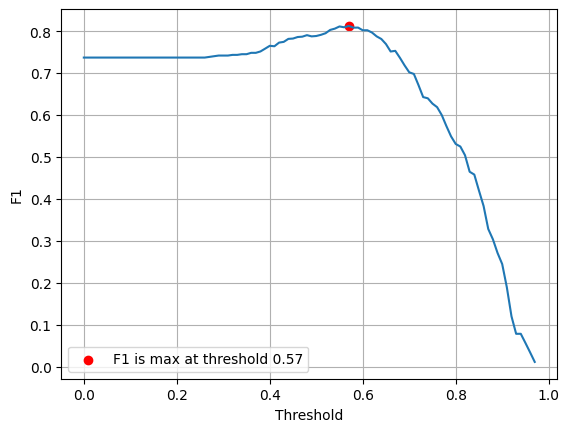

In [16]:
%matplotlib inline
plt.plot(valid_thresholds, f1_score)
plt.xlabel("Threshold")
plt.ylabel("F1")
plt.scatter(t_f1, max(f1), color='red', label=f"F1 is max at threshold {t_f1:.2f}")
plt.legend()
plt.grid(True)

## Question 5:
Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:
`KFold(n_splits = 5, shuffle = True, random_state = 1)`

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`

* Use AUC to evaluate the model on validation

How large is the standard deviation of the scores across the different folds?

In [17]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits = 5, shuffle = True, random_state = 1)
score = []
for train_idx, val_idx in kfold.split(data_full_train):
    df_train = data_full_train.iloc[train_idx]
    df_val = data_full_train.iloc[val_idx]
    y_train_kfold = y_full_train.iloc[train_idx]
    y_val_kfold = y_full_train.iloc[val_idx]

    # model training
    dv, model = train(df_train, y_train_kfold)

    dicts_val = df_val.to_dict(orient='records')
    X_val = dv.transform(dicts_val)
    y_pred_val = model.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val_kfold, y_pred_val)
    score.append(auc)

print(f"The standard deviation of the AUC across folds is {np.std(score):.3f}")


The standard deviation of the AUC across folds is 0.036


## Question 6: Hyperparameter Tuning
Now let's use kfold cross validation to find the bect parameter `C`:
* Iterate over the following `C` values `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round th mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [18]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits = 5, shuffle = True, random_state = 1)

for C in [0.000001, 0.001, 1]:
    scores = []
    for train_idx, val_idx in kfold.split(data_full_train):
        df_train = data_full_train.iloc[train_idx]
        df_val = data_full_train.iloc[val_idx]
        y_train_kfold = y_full_train.iloc[train_idx]
        y_val_kfold = y_full_train.iloc[val_idx]

        # model training
        dv, model = train(df_train, y_train_kfold, C=C)

        dicts_val = df_val.to_dict(orient='records')
        X_val = dv.transform(dicts_val)
        y_pred_val = model.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val_kfold, y_pred_val)
        scores.append(auc)

    print(f"C = {C}, mean = {np.mean(scores):.3f}, std = {np.std(scores):.3f}")




C = 1e-06, mean = 0.560, std = 0.024
C = 0.001, mean = 0.867, std = 0.029
C = 1, mean = 0.822, std = 0.036
